# Identifying political axes by clustering ballots

Inspired by the legendary "Tribes of Israel" post: https://sadnadearaa.blogspot.com/2013/01/blog-post_24.html,
which also inspired Omri Goldstein's post: https://www.themarker.com/techblogs/ormigoldstein/BLOG-1.7137465

In [1]:
import numpy as np
import dovpanda # comment this out in Kaggle
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Reading and pre-processing data
- Removing unnecessary columns
- Recognizing (multi-)index

===== Dataframe has 10901 rows. Column שם ישוב has only 1214 values which suggests it's a categorical feature.
After df is created, Consider converting it to categorical by using df['שם ישוב'] = df['שם ישוב'].astype('category') ===== (Line 1)
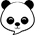

,סמל ועדה,ברזל,שם ישוב,סמל ישוב,קלפי,ריכוז,שופט,בזב,מצביעים,פסולים,...,פה,ףז,צ,צן,ץ,ק,קך,קץ,רק,שס
0,18,9797,אבו ג'ווייעד (שבט),967,1.0,1,0,559,113,2,...,9,0,0,0,0,1,0,0,0,0
1,18,9798,אבו ג'ווייעד (שבט),967,2.0,1,0,751,224,1,...,12,0,0,0,0,1,1,0,0,0
2,18,9799,אבו ג'ווייעד (שבט),967,3.0,1,0,651,205,6,...,1,0,0,0,0,1,0,0,0,0
3,2,733,אבו גוש,472,1.0,1,0,525,268,3,...,25,0,1,0,0,0,0,0,0,5
4,2,734,אבו גוש,472,2.0,1,0,686,363,6,...,33,0,0,0,0,2,1,0,0,6


In [2]:
df = pd.read_csv(r'votes per booth 2019b.csv',encoding='iso_8859_8')
df['שם ישוב'] = df['שם ישוב'].astype('category')
df.head()

In [3]:
new_supervision_fields = ['סמל ועדה', 'ברזל', 'שופט', 'ריכוז']
df.drop(new_supervision_fields, axis=1, inplace=True)

df.set_index(['שם ישוב', 'קלפי'], inplace=True)
df.drop('סמל ישוב', axis=1, inplace=True)

df.head()

בזב  מצביעים  פסולים  כשרים  אמת  ג  ודעם  ז  זכ  זן  \
שם ישוב            קלפי                                                         
אבו ג'ווייעד (שבט) 1.0   559      113       2    111    0  1   100  0   0   0   
                   2.0   751      224       1    223    3  0   202  0   0   0   
                   3.0   651      205       6    199    0  0   196  0   0   0   
אבו גוש            1.0   525      268       3    265    8  0   194  0   0   0   
                   2.0   686      363       6    357    5  0   290  0   0   0   

                        ...  פה  ףז  צ  צן  ץ  ק  קך  קץ  רק  שס  
שם ישוב            קלפי ...                                       
אבו ג'ווייעד (שבט) 1.0  ...   9   0  0   0  0  1   0   0   0   0  
                   2.0  ...  12   0  0   0  0  1   1   0   0   0  
                   3.0  ...   1   0  0   0  0  1   0   0   0   0  
אבו גוש            1.0  ...  25   0  1   0  0  0   0   0   0   5  
                   2.0  ...  33   0  0   0  0  2   1   0   0   6  

[5 rows x 36 columns]

### Check number of votes in each booth
- Can we say the booths are "pretty much the same size"?
- Do we need to drop anything?

In [4]:
metadata_fields = ['בזב','פסולים','מצביעים', 'כשרים']
df[metadata_fields].describe()

,בזב,פסולים,מצביעים,כשרים
count,10901.000000,10901.000000,10901.000000,10901.000000
mean,586.296487,2.601780,409.610861,407.009082
std,153.218193,7.004732,132.022112,131.442141
min,0.000000,0.000000,12.000000,0.000000
25%,544.000000,1.000000,334.000000,332.000000
50%,616.000000,2.000000,404.000000,402.000000
75%,680.000000,3.000000,470.000000,468.000000
max,816.000000,489.000000,1055.000000,1049.000000


In [5]:
df[metadata_fields].sort_values('כשרים', ascending=True)
# Note: 2 disqualified ballots boxes, some very small booths, exterior envelopes

,,בזב,פסולים,מצביעים,כשרים
שם ישוב,קלפי,,,,
שפרעם,34.0,744,489,489,0
עראבה,11.0,743,468,468,0
שער מנשה,1.0,131,1,12,11
ירושלים,994.0,301,0,18,18
איבים,1.0,107,0,24,24
אלוני יצחק,1.0,127,0,28,28
תראבין א-צאנע (שבט),1.0,511,0,33,33
עין קנייא,1.0,139,0,34,34
כפר סילבר,1.0,97,0,35,35


### Keep a dataframe containing only votes-per-party data

In [6]:
votes_df = df.drop(metadata_fields, axis=1)
votes_df = votes_df[votes_df.sum(axis=1)>0].copy()
normalized_votes = votes_df.div(votes_df.sum(axis=1), axis=0) 

votes_df.head()

אמת  ג  ודעם  ז  זכ  זן  זץ  טב  י  יז ...  פה  ףז  \
שם ישוב            קלפי                                         ...           
אבו ג'ווייעד (שבט) 1.0     0  1   100  0   0   0   0   0  0   0 ...   9   0   
                   2.0     3  0   202  0   0   0   0   0  0   0 ...  12   0   
                   3.0     0  0   196  0   0   0   0   0  0   0 ...   1   0   
אבו גוש            1.0     8  0   194  0   0   0   0   0  0   2 ...  25   0   
                   2.0     5  0   290  0   0   0   0   0  0   5 ...  33   0   

                         צ  צן  ץ  ק  קך  קץ  רק  שס  
שם ישוב            קלפי                               
אבו ג'ווייעד (שבט) 1.0   0   0  0  1   0   0   0   0  
                   2.0   0   0  0  1   1   0   0   0  
                   3.0   0   0  0  1   0   0   0   0  
אבו גוש            1.0   1   0  0  0   0   0   0   5  
                   2.0   0   0  0  2   1   0   0   6  

[5 rows x 32 columns]

### Sort parties by size, to observe only the major ones
- Note that this is not the same as the electoral threshold (אחוז החסימה)
- Still, a natural threshold usually arises

In [8]:
party_votes = votes_df.sum().div(votes_df.sum().sum()).sort_values(ascending=False)
print(party_votes.round(2))

parties = party_votes.index.values.tolist()
major_parties = party_votes[party_votes>0.01].index.values.tolist()

פה      0.26
מחל     0.25
ודעם    0.11
שס      0.07
ל       0.07
ג       0.06
טב      0.06
אמת     0.05
מרצ     0.04
כף      0.02
זץ      0.00
כי      0.00
יז      0.00
צ       0.00
רק      0.00
נך      0.00
ק       0.00
ףז      0.00
ז       0.00
נ       0.00
קץ      0.00
קך      0.00
זכ      0.00
צן      0.00
ינ      0.00
ץ       0.00
יף      0.00
יק      0.00
י       0.00
כ       0.00
נץ      0.00
זן      0.00
dtype: float64


## Cluster by K-means and plot
- K-means into 5 clusters, beacuse it fits well in a plot
- Clustering by normalized ballots
- Reducing dimensions to 2 with PCA

In [9]:
n_clusters = 7;  # Play with this on-line

k_means = KMeans(n_clusters=n_clusters, max_iter=100)
k_means.fit(normalized_votes)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [10]:
pca=PCA(n_components=2) # two components, for the plot
transformed_votes = pca.fit_transform(normalized_votes)
cluster_centers = pca.transform(k_means.cluster_centers_)

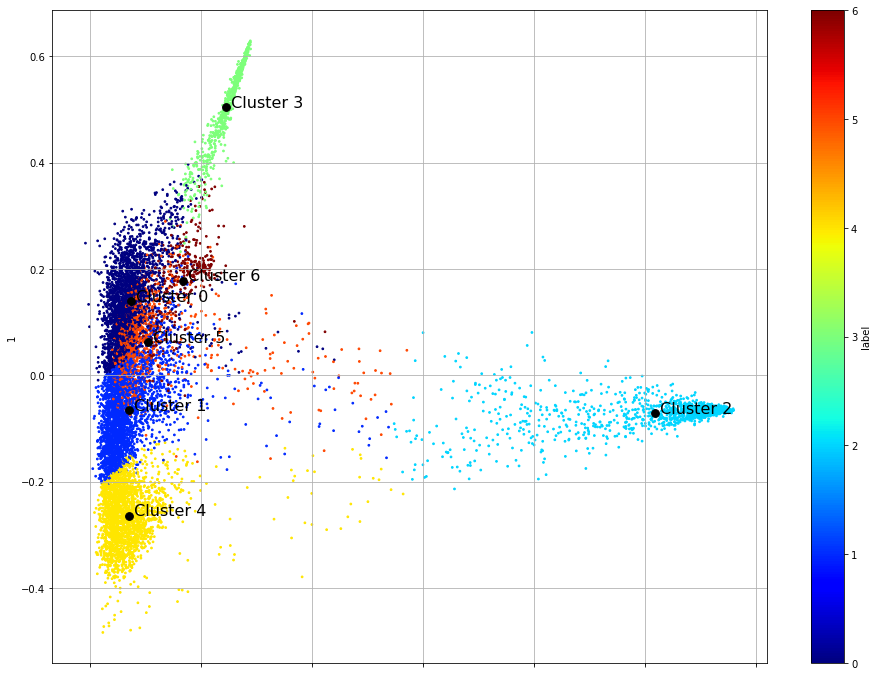

In [11]:
df_for_plot = pd.DataFrame(transformed_votes, columns=['x','y']).join(pd.Series(k_means.labels_, name='label'))
ax = df_for_plot.plot.scatter('x','y',c='label', figsize=(16,12), cmap='jet', style='.', s=3, grid=True)

pd.DataFrame(cluster_centers).plot.scatter(0,1,ax=ax, c='black', s=60, grid=True)

for cluster_label, cluster_center in enumerate(cluster_centers):
    plt.text(cluster_center[0], cluster_center[1] ,r' Cluster '+str(cluster_label), fontsize=16)

### Describe the cluster centers from the k_means model

In [12]:
cluster_sizes = pd.DataFrame.from_dict({'votes': votes_df.sum(axis=1), 'cluster': k_means.labels_}).groupby('cluster').sum()
cluster_sizes = cluster_sizes.div(cluster_sizes.sum()).round(2)

clusters_df = pd.DataFrame(columns = votes_df.columns, data=k_means.cluster_centers_)
clusters_df['size'] = cluster_sizes
clusters_df[['size'] + major_parties].round(2)

,size,פה,מחל,ודעם,שס,ל,ג,טב,אמת,מרצ,כף
0,0.21,0.15,0.45,0.01,0.14,0.07,0.03,0.06,0.04,0.01,0.03
1,0.27,0.34,0.30,0.01,0.05,0.07,0.02,0.06,0.06,0.04,0.02
2,0.11,0.04,0.01,0.86,0.01,0.01,0.00,0.00,0.01,0.03,0.00
3,0.08,0.01,0.06,0.00,0.26,0.01,0.58,0.03,0.00,0.00,0.03
4,0.20,0.52,0.14,0.01,0.01,0.05,0.00,0.03,0.09,0.12,0.01
5,0.09,0.19,0.34,0.02,0.06,0.26,0.02,0.03,0.03,0.01,0.01
6,0.03,0.07,0.19,0.00,0.05,0.01,0.04,0.50,0.02,0.01,0.10


In [13]:
with dovpanda.mute():
    for label, cluster in clusters_df.sort_values('size',ascending=False).iterrows():
        print('cluster label: {}'.format(label))
        print('cluster size: {}'.format(cluster['size']))
        print('top 5 parties:')
        print(cluster.drop('size').sort_values(ascending=False).head(5).round(2))
        print('\n')

cluster label: 1
cluster size: 0.27
top 5 parties:
פה     0.34
מחל    0.30
ל      0.07
טב     0.06
אמת    0.06
Name: 1, dtype: float64


cluster label: 0
cluster size: 0.21
top 5 parties:
מחל    0.45
פה     0.15
שס     0.14
ל      0.07
טב     0.06
Name: 0, dtype: float64


cluster label: 4
cluster size: 0.2
top 5 parties:
פה     0.52
מחל    0.14
מרצ    0.12
אמת    0.09
ל      0.05
Name: 4, dtype: float64


cluster label: 2
cluster size: 0.11
top 5 parties:
ודעם    0.86
פה      0.04
מרצ     0.03
מחל     0.01
אמת     0.01
Name: 2, dtype: float64


cluster label: 5
cluster size: 0.09
top 5 parties:
מחל    0.34
ל      0.26
פה     0.19
שס     0.06
אמת    0.03
Name: 5, dtype: float64


cluster label: 3
cluster size: 0.08
top 5 parties:
ג      0.58
שס     0.26
מחל    0.06
טב     0.03
כף     0.03
Name: 3, dtype: float64


cluster label: 6
cluster size: 0.03
top 5 parties:
טב     0.50
מחל    0.19
כף     0.10
פה     0.07
שס     0.05
Name: 6, dtype: float64




===== All dataframes have the same columns and same number of rows. Pay attention, your axis is 0 which concatenates vertically ===== (Line 16)
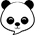

,שם ישוב,קלפי,פה,מחל,ודעם,שס,ל,ג,טב,אמת,מרצ,כף,cluster_label,cluster_name
2184,רחובות,7.0,86,166,0,28,21,9,15,4,1,16,0,TBD0
2058,קרית מלאכי,22.0,60,169,0,39,17,16,14,6,1,9,0,TBD0
369,באר יעקב,9.0,105,142,2,71,19,2,9,1,2,19,0,TBD0
1785,פתח תקווה,133.7,113,85,0,45,56,70,27,13,9,4,1,TBD1
327,הרצליה,20.0,169,179,0,34,24,25,30,25,25,7,1,TBD1
185,באר שבע,260.0,98,143,4,5,12,2,18,22,2,9,1,TBD1
793,נוף הגליל,35.0,36,28,177,2,6,2,6,8,11,3,2,TBD2
1126,רהט,32.0,10,2,332,0,0,3,2,12,8,0,2,TBD2
1183,שגב-שלום,3.0,2,2,479,0,2,0,0,2,2,1,2,TBD2
92,בית שמש,48.0,1,7,0,96,0,245,0,1,0,3,3,TBD3


In [14]:
cluster_names = {0: 'TBD0',
                1: 'TBD1',
                2: 'TBD2',
                3: 'TBD3',
                4: 'TBD4',
                5: 'TBD5',
                6: 'TBD6'}
assert(len(cluster_names)==n_clusters)

votes_to_major_with_cluster = votes_df[major_parties].copy()
votes_to_major_with_cluster['cluster_label'] = k_means.labels_
votes_to_major_with_cluster['cluster_name'] = votes_to_major_with_cluster['cluster_label'].map(cluster_names)

pd.concat([
    votes_to_major_with_cluster[votes_to_major_with_cluster['cluster_label']==cluster_label].reset_index().sample(3)
    for cluster_label in cluster_names.keys()])

# To do during workshop: cluster with NMF

In [15]:
# from sklearn.decomposition import NMF
# nmf = NMF(n_components=5)

# nmf.fit(votes_df)

# components_df = pd.DataFrame(nmf.components_, columns=parties)
# sorted_parties = components_df.sum().sort_values(ascending=False).index
# components_df[sorted_parties[:11]].round(1)

,זכ,ףז,ודעם,מחל,אמת,זן,ק,פה,ז,נך,טב
0,17.5,107.0,0.0,0.0,0.0,26.0,25.2,4.7,0.0,3.9,0.7
1,0.1,0.0,112.4,0.0,0.0,0.8,0.9,0.9,2.6,0.0,0.0
2,0.0,0.0,0.0,93.4,0.4,38.0,0.0,0.0,0.0,2.9,0.0
3,126.4,19.1,0.0,1.0,1.9,0.0,8.1,19.7,23.5,0.0,0.9
4,0.0,14.1,0.0,0.0,69.3,0.8,0.0,1.0,0.0,12.3,0.1
